In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [24]:
# Pg 145
# J&J Quarterly EPS since January 1960 to  december 1980
df = pd.read_csv('../data/jj.csv')
df.tail() # shape (84, 2)

,date,data
79,1979-10-01,9.99
80,1980-01-01,16.20
81,1980-04-01,14.67
82,1980-07-02,16.02
83,1980-10-01,11.61


In [3]:
train = df.iloc[:-4]
test= df.iloc[-4:]

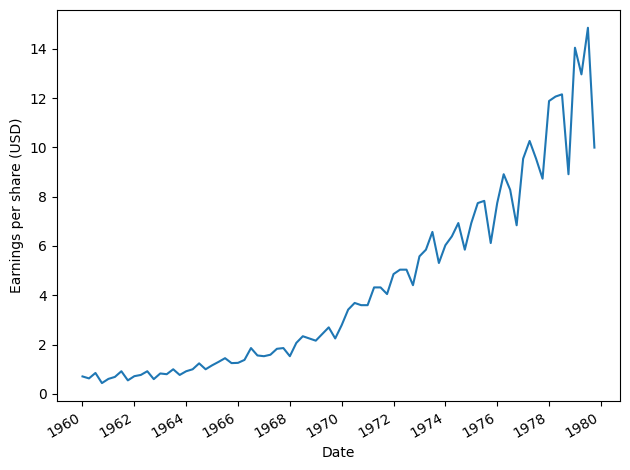

In [4]:
# Figure 7.5 in pg 147

fig, ax = plt.subplots()

ax.plot(train.date, train['data'])
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()


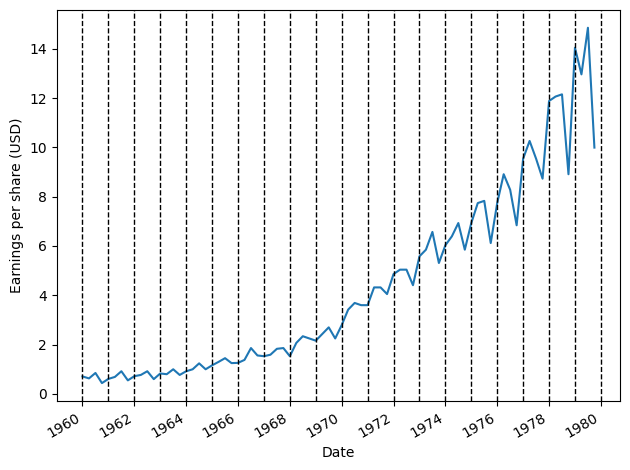

In [5]:
fig, ax = plt.subplots()

ax.plot(train.date, train['data'])
for i in np.arange(0, 84, 4):
    ax.axvline(x=i, linestyle='--', color='black', linewidth=1)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')

plt.xticks(np.arange(0, 84, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

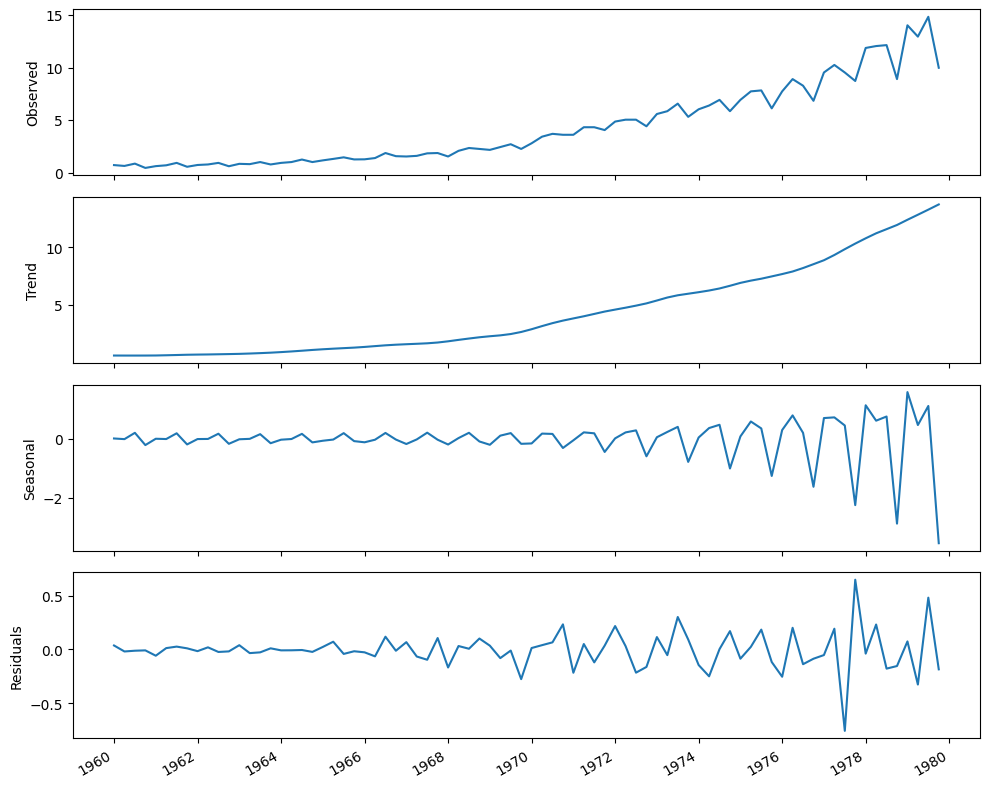

In [6]:
decomposition = STL(train['data'], period=4).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

plt.xticks(np.arange(0, 84, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

In [7]:
ad_fuller_result = adfuller(train['data'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 4.990525443391484
p-value: 1.0


In [8]:
df_seasonal_diff = np.diff(train['data'], n=4)

ad_fuller_result = adfuller(df_seasonal_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -5.171368012578263
p-value: 1.0055903310040308e-05


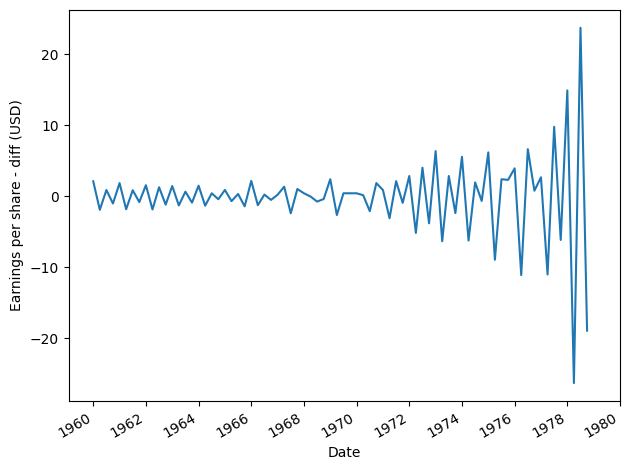

In [9]:
fig, ax = plt.subplots()

ax.plot(train['date'][4:], df_seasonal_diff)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share - diff (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

## d=0, D=1

In [10]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog, 
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [11]:
ps = range(0, 5, 1)
qs = range(0, 5, 1)
Ps = range(0, 5, 1)
Qs = range(0, 5, 1)

d = 0
D = 1
s = 4

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

SARIMA_result_df = optimize_SARIMA(train['data'], SARIMA_order_list, d, D, s)
SARIMA_result_df

  0%|          | 0/625 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(2, 2, 1, 4)",20.000000
1,"(2, 2, 0, 0)",94.492055
2,"(4, 1, 0, 0)",94.542262
3,"(2, 3, 0, 0)",94.663099
4,"(2, 4, 2, 0)",94.762957
...,...,...
436,"(0, 1, 0, 1)",146.712283
437,"(0, 0, 0, 2)",150.946452
438,"(0, 0, 0, 1)",164.363913
439,"(0, 1, 0, 0)",175.098492


***************************************************************************
Pick a Model and analyze residuals

We pick SARIMA(2,0,2)(1,1,4)_4, which has the lowest AIC

In [14]:
SARIMA_model = SARIMAX(train['data'], order=(2,0,2), seasonal_order=(1,1,4,4), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False, method='nm') # method='powell'

print(SARIMA_model_fit.summary())

                                          SARIMAX Results                                           
Dep. Variable:                                         data   No. Observations:                   80
Model:             SARIMAX(2, 0, 2)x(1, 1, [1, 2, 3, 4], 4)   Log Likelihood                 -82.539
Date:                                      Tue, 10 Feb 2026   AIC                            185.078
Time:                                              17:20:16   BIC                            208.385
Sample:                                                   0   HQIC                           194.393
                                                       - 80                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0007      0.279  

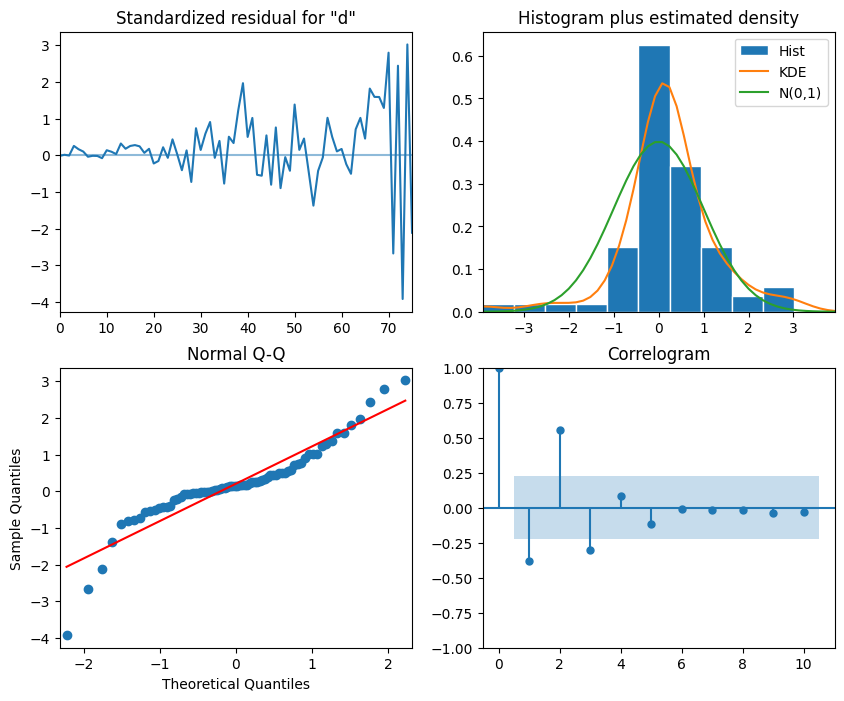

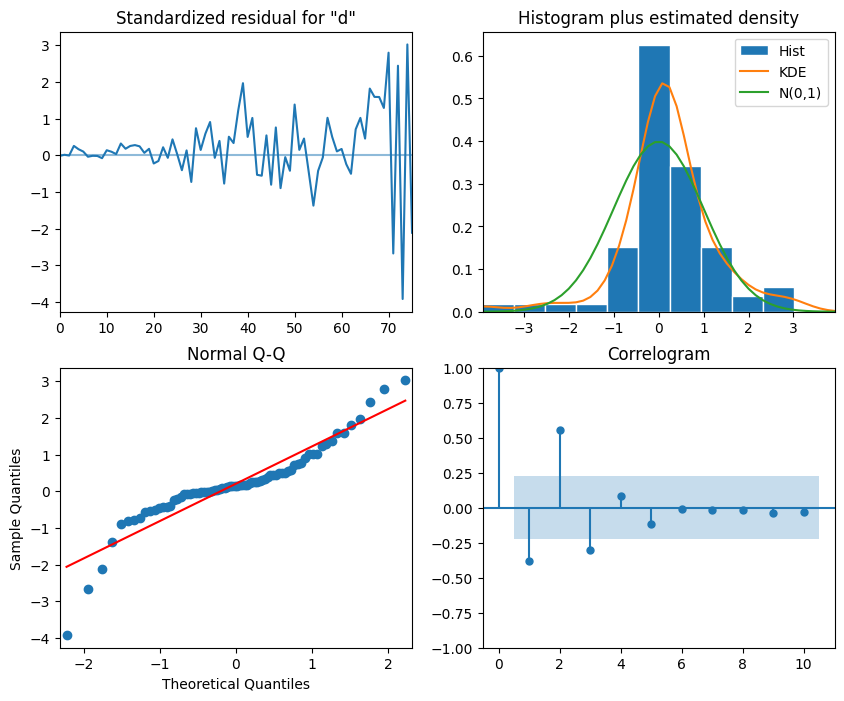

In [15]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8))

In [17]:
residuals = SARIMA_model_fit.resid

lb_dataframe = acorr_ljungbox(residuals, np.arange(1, 11, 1))

lb_dataframe

,lb_stat,lb_pvalue
1,9.704157,1.838517e-03
2,34.861926,2.690475e-08
3,42.113759,3.795189e-09
4,42.591517,1.257743e-08
5,43.789067,2.556188e-08
6,43.801130,8.094598e-08
7,43.820483,2.315110e-07
8,43.858160,6.051637e-07
9,44.054331,1.379265e-06
10,44.170177,3.067876e-06


SARIMA(2,0,2)(1,1,4)_4, , Ljung-Box test we can reject null hypothesis for lags 1 to lag 10  
Let's try, SARIMA(2,0,2)(0,1,0)_4

In [18]:
SARIMA_model = SARIMAX(train['data'], order=(2,0,2), seasonal_order=(0,1,0,4), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False, method='nm') # method='powell'

print(SARIMA_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               data   No. Observations:                   80
Model:             SARIMAX(2, 0, 2)x(0, 1, [], 4)   Log Likelihood                 -96.374
Date:                            Tue, 10 Feb 2026   AIC                            202.749
Time:                                    17:26:55   BIC                            214.402
Sample:                                         0   HQIC                           207.406
                                             - 80                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0025      5.800     -0.000      1.000     -11.370      11.365
ar.L2          0.0011      2.497   

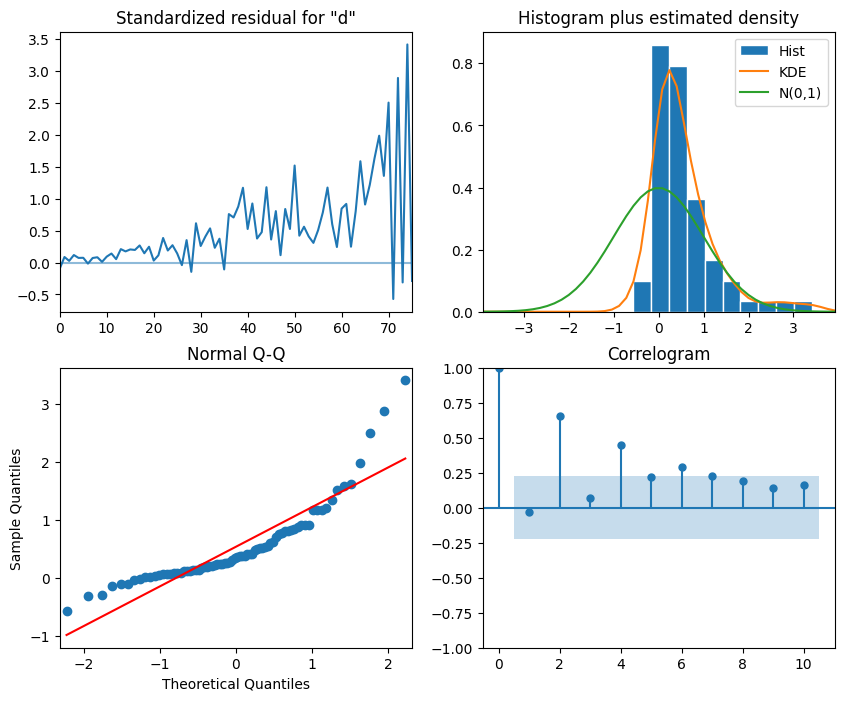

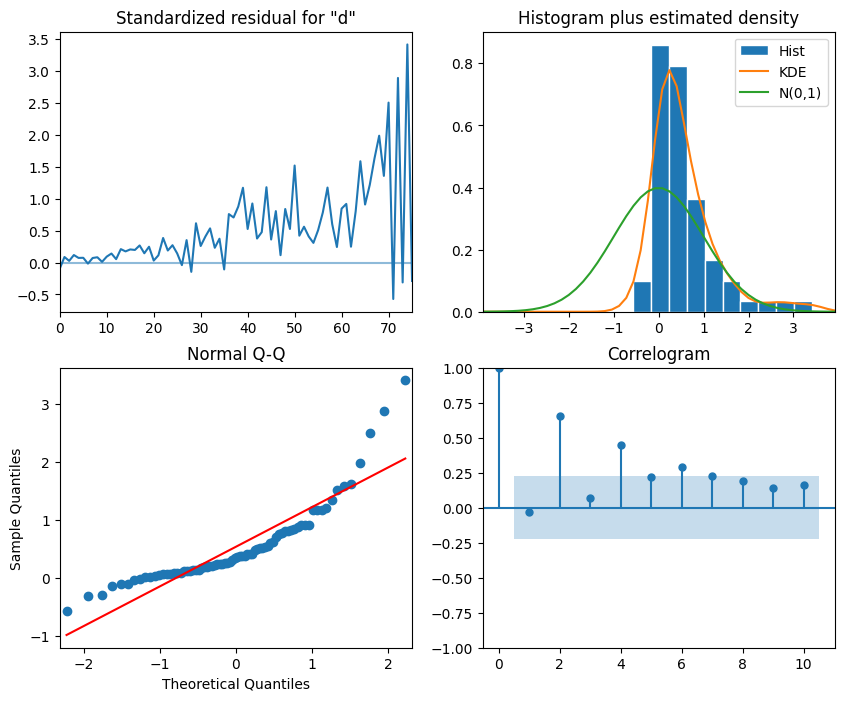

In [19]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8))

In [20]:
residuals = SARIMA_model_fit.resid

lb_dataframe = acorr_ljungbox(residuals, np.arange(1, 11, 1))

lb_dataframe

,lb_stat,lb_pvalue
1,0.082182,7.743619e-01
2,35.646974,1.817013e-08
3,35.962134,7.627697e-08
4,52.526102,1.070721e-10
5,56.386821,6.764526e-11
6,63.626309,8.226058e-12
7,67.876535,3.964129e-12
8,71.017099,3.082192e-12
9,72.727176,4.434206e-12
10,74.940433,4.886509e-12


SARIMA(2,0,2)(0,1,0)_4, , Ljung-Box test we can reject null hypothesis for lags 1 to lag 10  
Let's try, SARIMA(2,0,4)(2,1,0)_4

In [21]:
SARIMA_model = SARIMAX(train['data'], order=(2,0,4), seasonal_order=(2,1,0,4), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False, method='nm') # method='powell'

print(SARIMA_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               data   No. Observations:                   80
Model:             SARIMAX(2, 0, 4)x(2, 1, [], 4)   Log Likelihood                 -98.158
Date:                            Tue, 10 Feb 2026   AIC                            214.315
Time:                                    17:29:10   BIC                            235.292
Sample:                                         0   HQIC                           222.698
                                             - 80                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0006     16.447   3.94e-05      1.000     -32.235      32.236
ar.L2          0.0053     16.631   

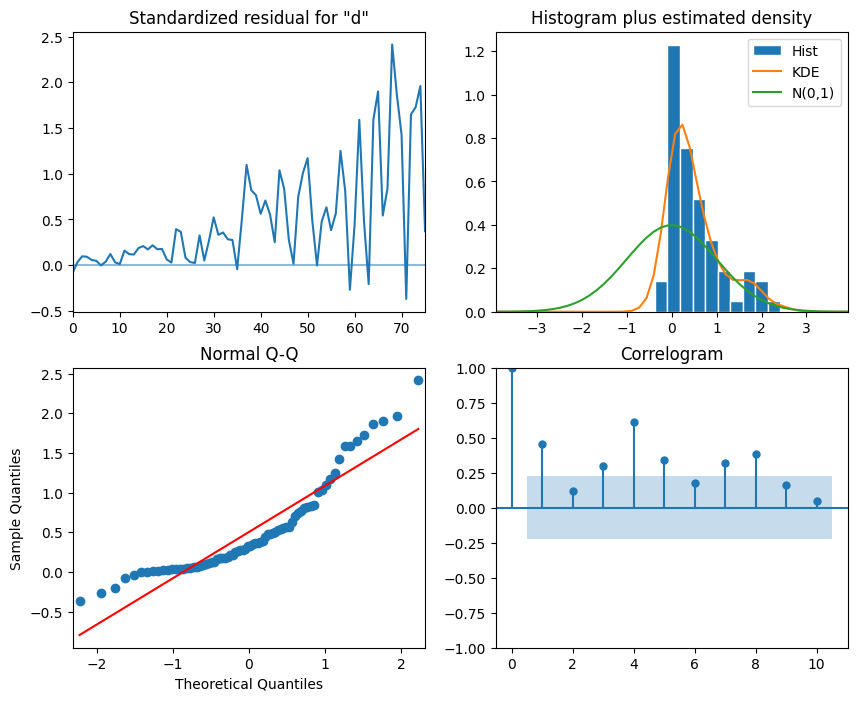

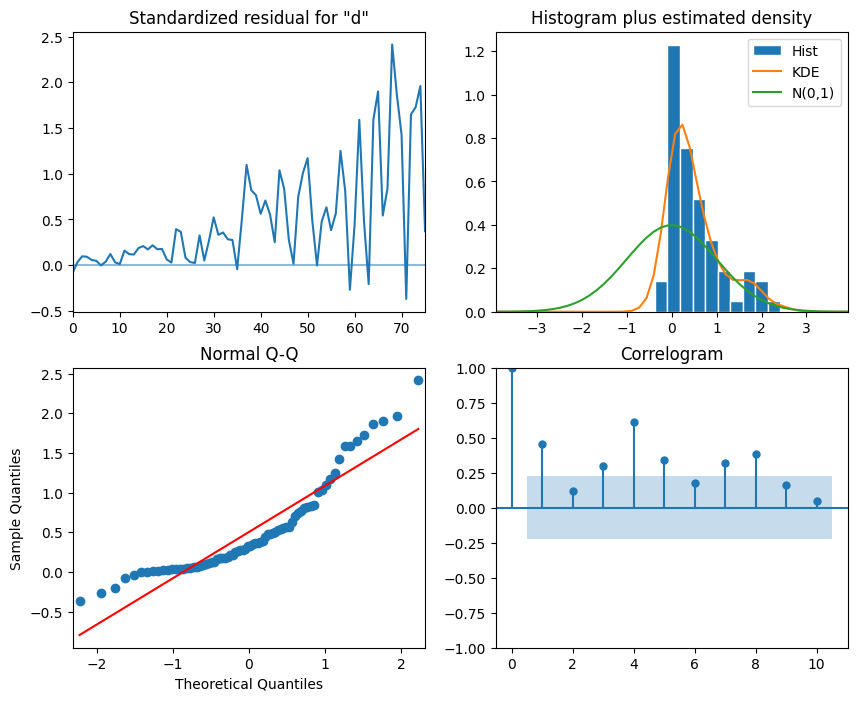

In [22]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8))

In [23]:
residuals = SARIMA_model_fit.resid

lb_dataframe = acorr_ljungbox(residuals, np.arange(1, 11, 1))

lb_dataframe

,lb_stat,lb_pvalue
1,17.090944,3.563181e-05
2,18.156969,1.140944e-04
3,25.466455,1.233390e-05
4,56.584829,1.511874e-11
5,66.126820,6.541518e-13
6,68.569935,8.030192e-13
7,77.109275,5.344111e-14
8,89.793615,5.121385e-16
9,92.039284,6.340651e-16
10,92.181387,1.976072e-15


We abandon. We will do d=1, D=1. Let's use the first combination for experimentation

We pick SARIMA(2,0,2)(1,1,4)_4, which has the lowest AIC

*******************************************************************************************
Forecast with model

In [ ]:
SARIMA_model = SARIMAX(train['data'], order=(2,0,2), seasonal_order=(1,1,4,4), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False, method='nm') # method='powell'

#print(SARIMA_model_fit.summary())

In [29]:
test['naive_seasonal'] = df['data'].iloc[76:80].values
test

,date,data,naive_seasonal
80,1980-01-01,16.20,14.04
81,1980-04-01,14.67,12.96
82,1980-07-02,16.02,14.85
83,1980-10-01,11.61,9.99


In [30]:
SARIMA_pred = SARIMA_model_fit.get_prediction(80, 84).predicted_mean

test['SARIMA_pred'] = SARIMA_pred
test

,date,data,naive_seasonal,SARIMA_pred
80,1980-01-01,16.20,14.04,14.799421
81,1980-04-01,14.67,12.96,12.717879
82,1980-07-02,16.02,14.85,14.500888
83,1980-10-01,11.61,9.99,9.926270


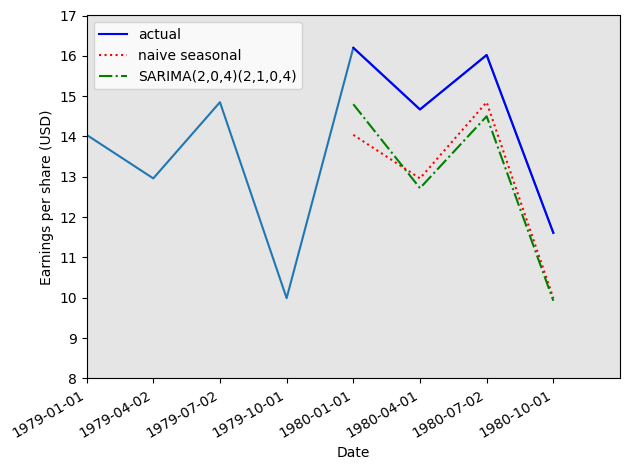

In [38]:
fig, ax = plt.subplots()

ax.plot(df['date'], df['data'])
ax.plot(test['data'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
#ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(11,2,3)')
ax.plot(test['SARIMA_pred'], 'g-.', label='SARIMA(2,0,4)(2,1,0,4)')

ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(75, 84, color='#808080', alpha=0.2)

ax.legend(loc=2)

ax.set_xlim(76, 84)
ax.set_ylim(8, 17)

fig.autofmt_xdate()
plt.tight_layout()


In [39]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [40]:
mape_naive_seasonal = mape(test['data'], test['naive_seasonal'])
mape_SARIMA = mape(test['data'], test['SARIMA_pred'])

print(mape_naive_seasonal, mape_SARIMA)

11.561658552433654 11.484362674374509
